## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

### 參考讀物   
- [大話文本識別經典模型：CRNN](https://kknews.cc/zh-tw/tech/pvgpqk8.html)   



In [1]:
# !pip install captcha  # 實作前安裝
 
import numpy as np
import string
import random
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 產生驗證碼

Text(0.5, 1.0, 'FR8V')

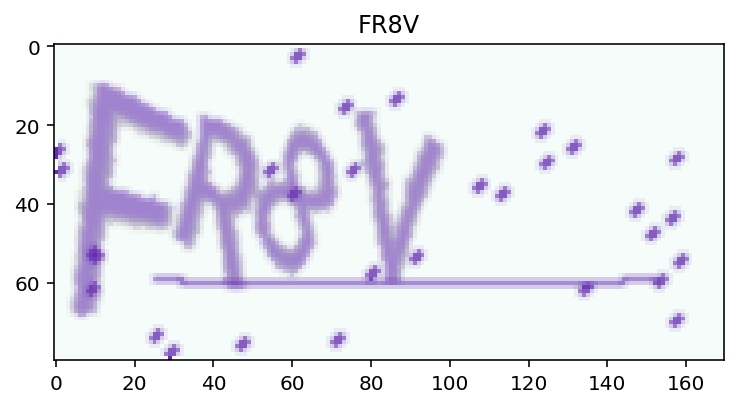

In [2]:
# 驗證碼包含數字 0-10 及 26 個大寫英文字母
characters = string.digits + string.ascii_uppercase

# 設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

# 設定產生驗證碼的 generator
generator = ImageCaptcha( width=width, height=height )

# 練習固定長度 4 個字的驗證碼
random_str = ''.join( [random.choice(characters) for j in range(4)] )
img = generator.generate_image( random_str )

# 顯示驗證碼
plt.imshow(img)
plt.title(random_str)

### 搭建一個 CNN 模型使得 Output Feature Map 高度壓縮成小於 4 且 8 < 寬度 < 20   
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Lambda

## CTC Loss

In [4]:
def ctc_lambda_func( args ):
    '''
    CTC Loss需要四個資訊，分別為:
    標籤(Label)、預測(y_pred)、CNN OUTPUT 的寬度、預測影像所包含文字長度
    '''
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost( labels, y_pred, input_length, label_length )

## CNN Model   

#### References:  
  - [Reshape layer](https://keras.io/api/layers/reshaping_layers/reshape/)   
  - [Lambda Layer](https://keras.io/api/layers/core_layers/lambda/)   

In [5]:
input_tensor = Input( (height,width,3) )
x = input_tensor

for i in range(4):
    x = Conv2D( 32, (3,3), activation='relu' )(x)
    x = BatchNormalization( )(x)
    x = Conv2D( 32, (3,3), activation='relu' )(x)
    x = BatchNormalization( )(x)
    if i < 3:
        x = MaxPooling2D( pool_size=(2,2) )(x)
    else:
        x = MaxPooling2D( pool_size=(2,1) )(x)

# 記錄輸出 CNN 尺寸(因 loss部分需要這個資訊
# Conv_Shape = ( Batch_size, 輸出高度, 輸出寬度, 輸出深度 )
Conv_Shape = x.get_shape()

# 將 ( Batch_size, 輸出高度, 輸出寬度, 輸出深度 ) 轉變成 ( Batch_size, 輸出寬度, 輸出深度*輸出高度 )
x = Reshape( target_shape=(int(Conv_Shape[2]),int(Conv_Shape[1]*Conv_Shape[3])) )(x)

x = Dense( 32, activation='relu' )(x)
x = Dropout( 0.25 )(x)
x = Dense( n_class, activation='softmax' )(x)
Base_Model = Model( inputs=input_tensor, outputs=x )

In [6]:
# 設定要給 CTC Loss的資訊
labels = Input( shape=[n_len], dtype='float32', name='Labels' )
input_length = Input( shape=[1], dtype='int64', name='Input_Length' )
label_length = Input( shape=[1], dtype='int64', name='Label_Length' )
loss_out = Lambda( ctc_lambda_func, output_shape=(1,), name='CTC_Loss' )([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model( inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out] )

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile( loss={'CTC_Loss': lambda y_true, y_pred: y_pred}, optimizer='SGD' )

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 78, 168, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization[0][0]        
____________________________________________________________________________________________

## Traning Data

In [8]:
# 定義 generator產生 training data
# 產生包含要給 loss 的資訊
# X=輸入影像
# np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
# np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join( [random.choice(characters) for j in range(4)] )
            X[i] = np.array( generator.generate_image(random_str) )
            y[i] = [ characters.find(x) for x in random_str ]
        yield [ X, y, np.ones(batch_size)*int(Conv_Shape[2]), np.ones(batch_size)*n_len ], np.ones(batch_size)

Label:  [[30 23  0  2]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


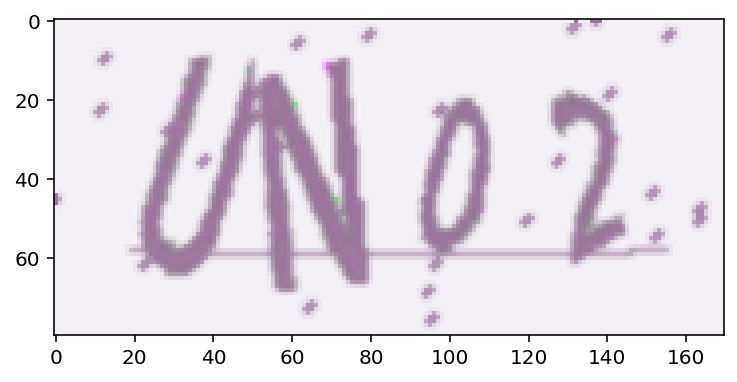

In [9]:
next_ge = gen(batch_size=1)
test_ge = next(next_ge)
plt.imshow( test_ge[0][0][0] )
print( 'Label: ',test_ge[0][1] )
print( 'CNN輸出寬度: ',test_ge[0][2] )
print( '字串長度(可浮動): ',test_ge[0][3] )

## 訓練模型

In [10]:
model.fit( gen(32), steps_per_epoch=300, epochs=30 )

  ...
    to  
  ['...']
Train for 300 steps
Epoch 1/30
300/300 [==============================] - 33s 109ms/step - loss: 15.4746
Epoch 2/30
300/300 [==============================] - 35s 115ms/step - loss: 11.7798
Epoch 3/30
300/300 [==============================] - 35s 116ms/step - loss: 8.0098
Epoch 4/30
300/300 [==============================] - 35s 116ms/step - loss: 6.0653
Epoch 5/30
300/300 [==============================] - 35s 115ms/step - loss: 4.9882
Epoch 6/30
300/300 [==============================] - 35s 117ms/step - loss: 4.3201
Epoch 7/30
300/300 [==============================] - 35s 116ms/step - loss: 3.8414
Epoch 8/30
300/300 [==============================] - 35s 116ms/step - loss: 3.7116
Epoch 9/30
300/300 [==============================] - 35s 115ms/step - loss: 3.4264
Epoch 10/30
300/300 [==============================] - 35s 117ms/step - loss: 3.2276
Epoch 11/30
300/300 [==============================] - 35s 117ms/step - loss: 3.2116
Epoch 12/30
300/300 [======

## 預測

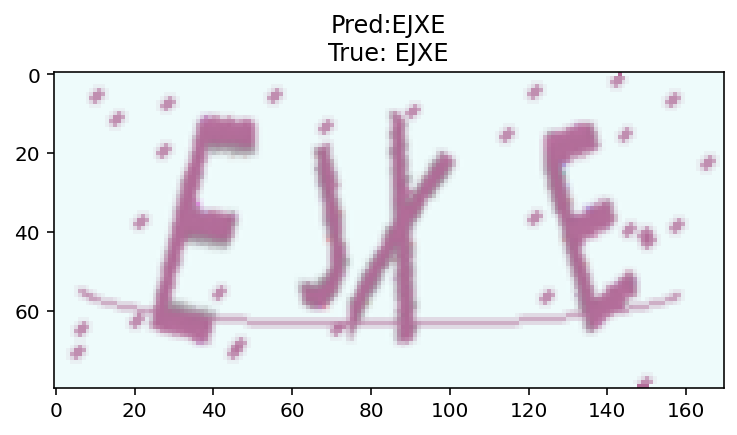

In [27]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = Base_Model.predict(X_test)

# 用 ctc_decode 得到解答，自己寫可以參考下方
out = K.get_value( K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('Pred:' + str(out) + '\nTrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [15]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [37]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 78, 168, 32)  128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm